# Brainspan in DK

In [1]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Import local code
import sys
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/brainspanPlots.R");

## Get brainspan RNAseq data

In [3]:
bs_dir = "../data/brainspan-data/gene_matrix_rnaseq/"
bs_exp, bs_col, bs_row = get_brainspan(bs_dir)

## Define Brainspan to DK mapping

In [4]:
dk_bs_mapping = get_dk_bs_mapping()

In [5]:
hcp_bs_mapping = get_hcp_bs_mapping()

In [6]:
hcp_bs_mapping_v2 = get_hcp_bs_mapping_v2()

In [944]:
hcp_bs_mapping_dk = (
    pd.read_csv("../data/hcp_bs_mapping_dk.csv", index_col=None)
    # .assign(keep = lambda x: np.where(np.isin(x['label'], ['6ma', 's6-8', '6mp']), np.nan, x['keep']))
    # .assign(keep = lambda x: np.where(np.isin(x['label'], ['p24pr']), np.nan, x['keep']))
    .assign(structure_name = lambda x: np.where(x['keep']==1, x['structure_name'], np.nan))
    # .assign(structure_name = lambda x: np.where(np.isin(x['label'], ['TF']), 'inferolateral temporal cortex (area TEv, area 20)', x['structure_name']))
           )

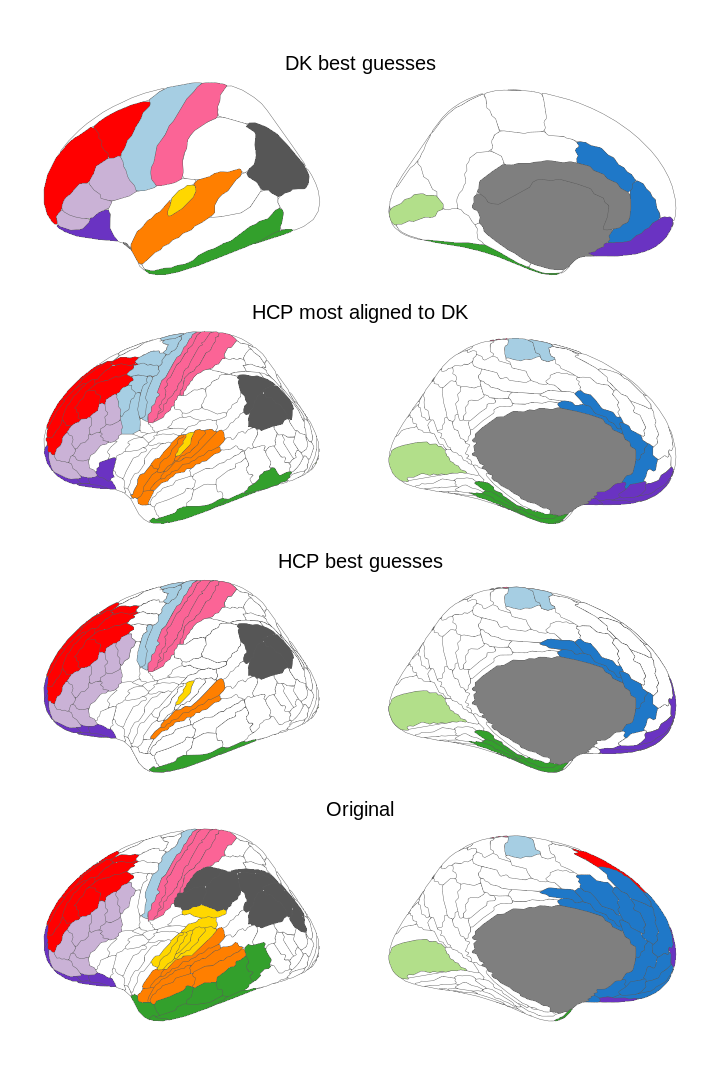

In [1082]:
%%R -w 10 -h 15 --units in -i dk_bs_mapping -i hcp_bs_mapping -i hcp_bs_mapping_v2 -i hcp_bs_mapping_dk
source("../code/brainspanPlots.R")
g1 <- plot_bs_dk_mapping(dk_bs_mapping) + ggtitle('DK best guesses')
g2 <- plot_bs_hcp_mapping(hcp_bs_mapping_dk) + ggtitle('HCP most aligned to DK')
g3 <- plot_bs_hcp_mapping(hcp_bs_mapping_v2) + ggtitle('HCP best guesses')
g4 <- plot_bs_hcp_mapping(hcp_bs_mapping) + ggtitle('Original')
g1 / g2 / g3 / g4

In [ ]:
# pca_dk_ds9 = gradientVersion(approach='pca').fit('dk_ds9')
# pca_dk_ds5 = gradientVersion(approach='pca').fit('dk_ds5')
# dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
# dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
# # dm_hcp_ds8 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds8')
# pca_hcp_ds9 = gradientVersion(approach='pca').fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

In [1084]:
# version = dm_dk_ds9
# version = pca_dk_ds9
# version = dm_hcp_ds8
# version = pca_hcp_ds9
version = dm_hcp_3d_ds5

# dk_from_hcp = pca_dk_ds5
# dk_from_hcp.scores = dk_from_hcp.score_from(dm_hcp_3d_ds5)
# dk_from_hcp.weights = dm_hcp_3d_ds5.weights.copy()
# version = dk_from_hcp


dk_from_hcp_v = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
dk_from_hcp_v.scores = dk_from_hcp_v.score_in_dk()
version = dk_from_hcp_v

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [1089]:
# bs_mapping = get_hcp_bs_mapping()
# bs_mapping = hcp_bs_mapping_v2.drop('keep',axis=1)
# bs_mapping = hcp_bs_mapping_dk.drop('keep',axis=1)
bs_mapping = dk_bs_mapping

In [1090]:
bs_scores = compute_brainspan_scores(bs_agg, version)
mapped_scores = get_mapped_scores(version, bs_mapping)
bs_scores_corr = correlate_bs_scores(bs_scores, mapped_scores, age_groups=get_age_groups())
both_scores, corrs = combine_scores(bs_scores, mapped_scores, age_groups)
scores_plot = make_brain_plots(version, bs_mapping, bs_scores)
ahba_scores = version.clean_scores().assign(version='')

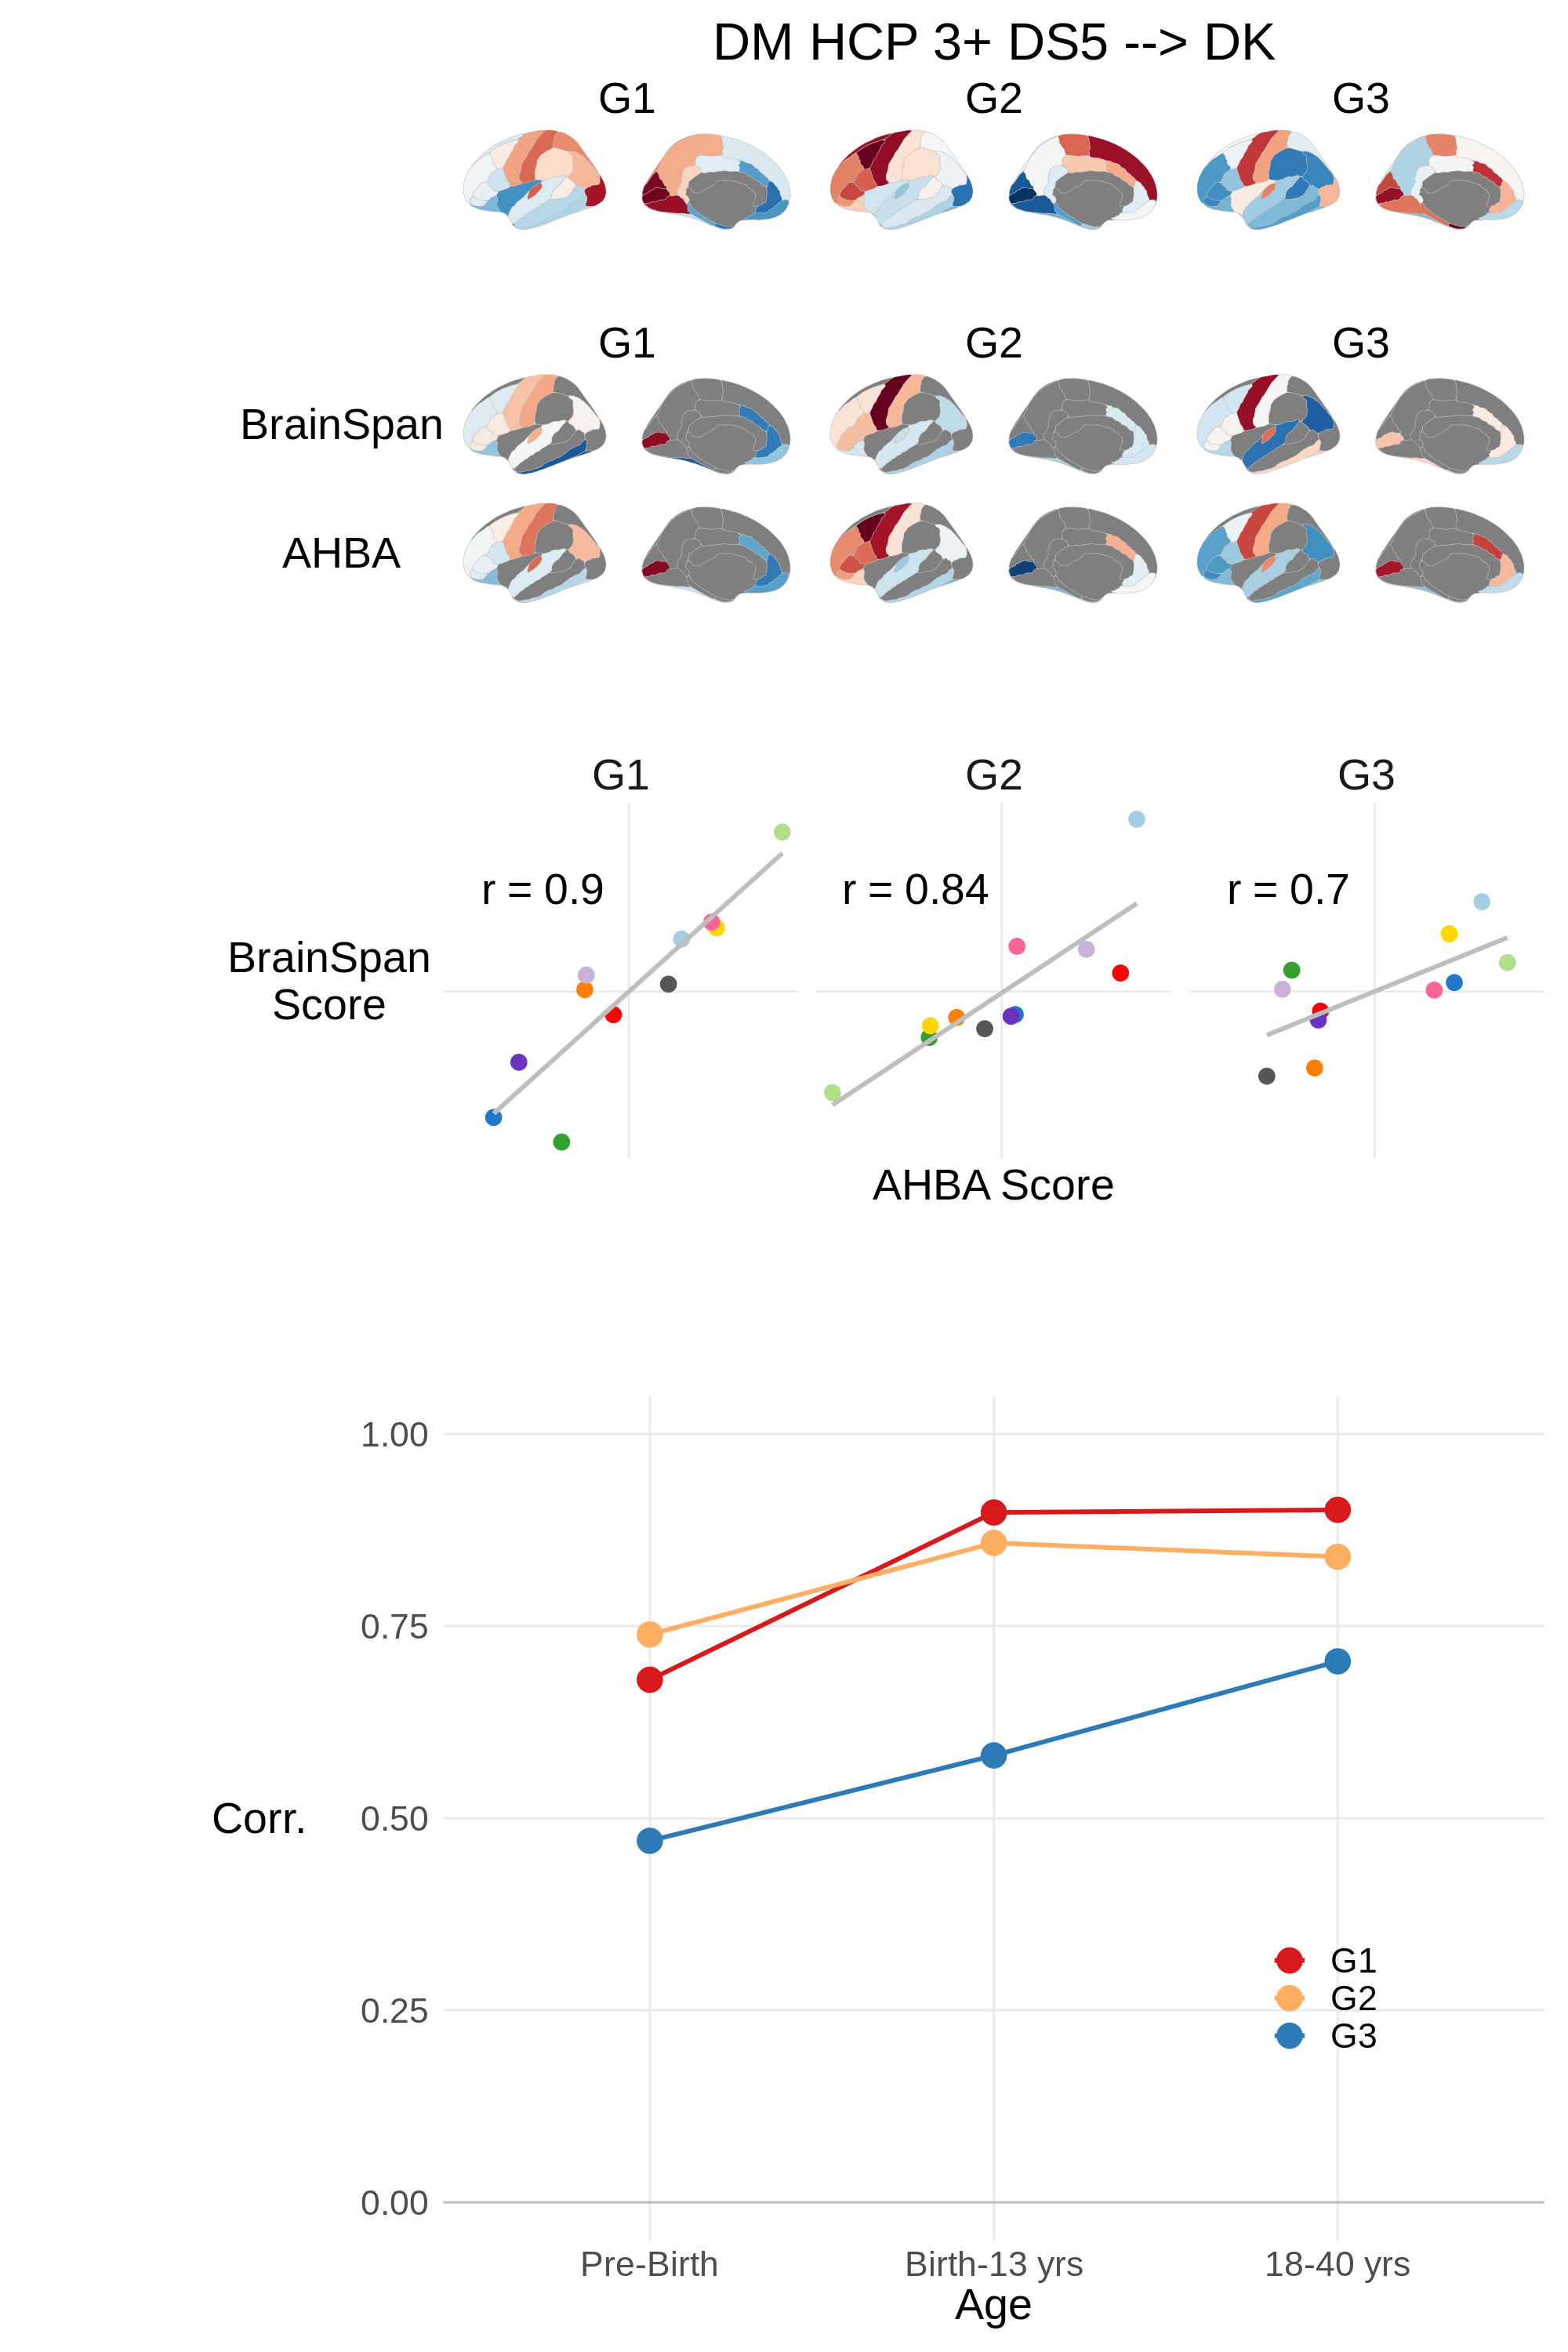

In [1093]:
%%R -w 10 -h 15 --units in -r 200 -i bs_mapping -i bs_scores_corr -i both_scores -i corrs -i scores_plot -i ahba_scores
source("../code/brainspanPlots.R")
source("../code/brainPlots.R")

g0 <- plot_dk(ahba_scores, facet='v') + guides(fill='none') + ggtitle('DM HCP 3+ DS5 --> DK')
# g0 <- plot_hcp(ahba_scores, facet='v') + guides(fill='none') + ggtitle('DM HCP 3+ DS5 --> DK (vertices)')
g1 <- plot_dk(scores_plot, facet='v', switch='y') + theme(
            strip.text.x=element_text(size=20), 
            strip.text.y.left=element_text(size=20),
            legend.position='none',
            plot.tag.position = c(0.1, 1)
            )
g2 <- plot_ahba_bs_scatter(both_scores, corrs, facet='h', size=3) + plot_layout(tag_level='new')
g3 <- plot_bs_scores_corr(bs_scores_corr) + 
    theme(
        axis.text.y=element_text(margin=margin(r=-90, unit='pt')),
        axis.title.y=element_text(margin=margin(r=-120, unit='pt'), angle=0, vjust=0.5),
        text=element_text(size=20), legend.position=c(.8,.3),  
        plot.tag.position = c(0.1, 1)
        )

layout <- c(
    area(t=1,b=3,l=1,r=2),
    area(t=4,b=9,l=1,r=2),
    area(t=10,b=21,l=1,r=2),
    area(t=22,b=39,l=1,r=2)
)
    
plot <- g0 + g1 + g2 + g3 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20), 
    strip.text=element_text(size=20),
    strip.text.x=element_text(size=20),
    strip.text.y=element_text(size=20),
    # plot.margin = margin(t=10, r=10, b=10, l=10, "pt"),
    plot.tag = element_text(size=28, face='bold')
)

themed

---

In [209]:
hcp_bs_mapping = get_hcp_bs_mapping(get_bs_cortex_mapping())
hcp_bs_mapping

,label,cortex,structure_name,structure_name_short
179,p24,Anterior_Cingulate_and_Medial_Prefrontal,anterior (rostral) cingulate (medial prefronta...,medial prefrontal cortex
87,10v,Anterior_Cingulate_and_Medial_Prefrontal,anterior (rostral) cingulate (medial prefronta...,medial prefrontal cortex
178,a32pr,Anterior_Cingulate_and_Medial_Prefrontal,anterior (rostral) cingulate (medial prefronta...,medial prefrontal cortex
64,10r,Anterior_Cingulate_and_Medial_Prefrontal,anterior (rostral) cingulate (medial prefronta...,medial prefrontal cortex
63,p32,Anterior_Cingulate_and_Medial_Prefrontal,anterior (rostral) cingulate (medial prefronta...,medial prefrontal cortex
...,...,...,...,...
162,VVC,Ventral_Stream_Visual,NaN,NaN
166,PoI1,Insular_and_Frontal_Opercular,NaN,NaN
167,Ig,Insular_and_Frontal_Opercular,NaN,NaN
168,FOP5,Insular_and_Frontal_Opercular,NaN,NaN


In [191]:
hcp_mapped_scores = get_mapped_scores(dm_hcp_3d_ds5, hcp_bs_mapping)
hcp_mapped_scores

,G1,G2,G3
structure_name,,,
anterior (rostral) cingulate (medial prefrontal) cortex,-1.339324,0.293157,0.245562
dorsolateral prefrontal cortex,-0.242882,1.302798,-0.538571
"inferolateral temporal cortex (area TEv, area 20)",-1.116485,-0.645017,-0.708186
orbital frontal cortex,-1.154716,0.171553,-0.869735
posterior (caudal) superior temporal cortex (area 22c),-0.711543,-0.553118,-0.888719
posteroventral (inferior) parietal cortex,0.402290,-0.164211,-1.029558
primary auditory cortex (core),0.569069,-0.960262,0.573388
"primary motor cortex (area M1, area 4)",0.983817,1.486373,1.682164
"primary somatosensory cortex (area S1, areas 3,1,2)",1.134395,0.150655,0.988335


In [192]:
correlate_bs_scores(bs_scores, hcp_mapped_scores, age_groups=get_age_groups())

,age,G,corr
0,Pre-Birth,G1,0.800821
1,Birth-13 yrs,G1,0.899512
2,18-40 yrs,G1,0.922463
3,Pre-Birth,G2,0.763237
4,Birth-13 yrs,G2,0.840378
5,18-40 yrs,G2,0.818858
6,Pre-Birth,G3,0.387955
7,Birth-13 yrs,G3,0.525706
8,18-40 yrs,G3,0.744491


In [185]:
bs_scores = compute_brainspan_scores(bs_agg, dm_hcp_3d_ds5)

In [199]:
hcp_mapped_scores = get_mapped_scores(dm_hcp_3d_ds5, hcp_bs_mapping, mean=True)

In [203]:
both_scores, corrs = combine_scores(bs_scores, hcp_mapped_scores, age_groups)

In [212]:
get_mapped_scores(dm_hcp_3d_ds5, hcp_bs_mapping, mean=False)

,G1,G2,G3,cortex,structure_name,structure_name_short
label,,,,,,
V1,2.118307,-2.126400,1.870976,Primary_Visual,"primary visual cortex (striate cortex, area V1...",primary visual cortex
4,1.265459,1.470708,2.009710,Motor,"primary motor cortex (area M1, area 4)",primary motor cortex
3b,1.749286,-0.286152,2.366837,Somatosensory,"primary somatosensory cortex (area S1, areas 3...",primary somatosensory cortex
A1,1.651745,-0.875657,1.993388,Early_Auditory,primary auditory cortex (core),primary auditory cortex
SFL,0.039856,2.127983,0.799195,Dorsolateral_Prefrontal,dorsolateral prefrontal cortex,dorsolateral prefrontal cortex
...,...,...,...,...,...,...
MBelt,1.130813,-1.031927,0.432620,Early_Auditory,primary auditory cortex (core),primary auditory cortex
A4,0.289825,-0.215973,-1.351517,Auditory_Association,posterior (caudal) superior temporal cortex (a...,posterior superior temporal cortex
STSva,-0.954546,-0.567244,-0.269966,Auditory_Association,posterior (caudal) superior temporal cortex (a...,posterior superior temporal cortex


In [213]:
make_brain_plots(dm_hcp_3d_ds5, hcp_bs_mapping, bs_scores)

,version,label,G1,G2,G3
0,BrainSpan,p24,-1.244406,-0.338891,0.515521
1,BrainSpan,10v,-1.244406,-0.338891,0.515521
2,BrainSpan,a32pr,-1.244406,-0.338891,0.515521
3,BrainSpan,10r,-1.244406,-0.338891,0.515521
4,BrainSpan,p32,-1.244406,-0.338891,0.515521
...,...,...,...,...,...
154,AHBA,MBelt,1.384165,-1.284863,0.534122
155,AHBA,A4,0.512536,-0.398634,-1.211882
156,AHBA,STSva,-0.777173,-0.780158,-0.153447
157,AHBA,TE1m,-0.727576,-0.303395,-0.689749
